In [1]:
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn.functional as F
from datasets import load_from_disk

In [3]:
sys.path.append("/mnt/storage2/arafat_shovon/flow_matching_and_llm/notebooks")

In [4]:
from transformers import(
    Blip2ForConditionalGeneration,
    Blip2Processor
)

**Load the Model**

In [5]:
model_name = "Salesforce/blip2-opt-2.7b"

processor = Blip2Processor.from_pretrained(model_name, 
                                        cache_dir="../data/cache")

model = Blip2ForConditionalGeneration.from_pretrained(model_name,
                                                    torch_dtype=torch.float16,
                                                    cache_dir="../data/cache",
                                                    attn_implementation="eager",
                                                    device_map="auto")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

**Load the Dataset**

In [6]:
data = load_from_disk("../data/flickr8k/train")

**GradCam Class**

In [26]:
class BLIP2GradECLIP:
    """
    Grad-eCLIP for BLIP2 Image Captioning - Memory Efficient (Half Precision)
    """
    
    def __init__(self, model, processor):
        self.model = model
        self.processor = processor
        self.device = next(model.parameters()).device
        self.dtype = torch.float16
        
        self.num_heads = model.vision_model.config.num_attention_heads
        self.hidden_size = model.vision_model.config.hidden_size
        self.head_dim = self.hidden_size // self.num_heads
        
        self.q = None
        self.k = None
        self.v = None
        self.attn_output = None
        
        self._register_hooks()
    
    def _register_hooks(self):
        """Register hooks to capture Q, K, V and attention output."""
        last_layer = self.model.vision_model.encoder.layers[-1]
        self_attn = last_layer.self_attn
        
        def qkv_hook(module, input, output):
            B, N, _ = output.shape
            qkv = output.reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
            
            self.q = qkv[0].detach().half()
            self.k = qkv[1].detach().half()
            self.v = qkv[2].detach().half()
        
        def attn_output_hook(module, input, output):
            if isinstance(output, tuple):
                self.attn_output = output[0]
            else:
                self.attn_output = output
        
        self.qkv_handle = self_attn.qkv.register_forward_hook(qkv_hook)
        self.attn_handle = last_layer.self_attn.register_forward_hook(attn_output_hook)
    
    def remove_hooks(self):
        self.qkv_handle.remove()
        self.attn_handle.remove()
    
    @torch.cuda.amp.autocast(dtype=torch.float16)
    def generate_gradcam(self, image):
        """Generate Grad-eCLIP attention map in half precision."""
        orig_size = image.size
        
        inputs = self.processor(images=image, text="Descrive this image", return_tensors="pt").to(self.device)
        pixel_values = inputs['pixel_values'].half()
        input_ids=inputs['input_ids']
        
        self.model.eval()
        
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            generated_ids = self.model.generate(
                pixel_values=pixel_values,
                input_ids=input_ids,
                max_new_tokens=30  # Reduced for memory
            )
        caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
        
        # Clear cache after generation
        torch.cuda.empty_cache()
        
        # Reset captured values
        self.q = None
        self.k = None
        self.v = None
        self.attn_output = None
        
        # Get feature map size
        img_size = pixel_values.shape[-1]
        patch_size = self.model.vision_model.config.patch_size
        feat_h = feat_w = img_size // patch_size
        
        # Step 2: Forward pass with gradients
        outputs = self.model(
            pixel_values=pixel_values,
            labels=generated_ids,
            input_ids=generated_ids,
            return_dict=True
        )
        
        score = outputs.loss
        
        # Step 3: Compute gradient
        if self.attn_output is None:
            raise ValueError("Attention output not captured!")
        
        grad = torch.autograd.grad(
            score,
            self.attn_output,
            retain_graph=False  # Don't retain to save memory
        )[0]
        grad = grad.detach().half()
        
        # Clear cache
        torch.cuda.empty_cache()
        
        print(f"Gradient shape: {grad.shape}")
        print(f"Q: {self.q.shape}, K: {self.k.shape}, V: {self.v.shape}")
        print(f"Feature map: {feat_h}x{feat_w}")
        
        # Step 4: Compute Grad-eCLIP map
        head_idx = 4
        
        grad_cls = grad[:, :1, :]
        q_cls = self.q[:, head_idx, :1, :]
        k_patch = self.k[:, head_idx, 1:, :]
        v_patch = self.v[:, head_idx, 1:, :]
        
        # Cosine similarity
        q_cls_norm = F.normalize(q_cls, dim=-1)
        k_patch_norm = F.normalize(k_patch, dim=-1)
        cosine_qk = (q_cls_norm * k_patch_norm).sum(-1)
        cosine_qk = (cosine_qk - cosine_qk.min()) / (cosine_qk.max() - cosine_qk.min() + 1e-8)
        
        grad_cls_head = grad_cls[:, :, head_idx * self.head_dim:(head_idx + 1) * self.head_dim]
        
        # Grad-eCLIP formula
        emap = F.relu((grad_cls_head * v_patch * cosine_qk.unsqueeze(-1)).sum(-1))
        emap = emap[0].reshape(feat_h, feat_w)
            
        # Normalize
        emap = emap - emap.min()
        if emap.max() > 0:
            emap = emap / emap.max()
        
        emap = emap.detach().cpu().float().numpy()
        emap_resized = cv2.resize(emap, orig_size)
        
        # Clean up to free memory
        del grad, self.q, self.k, self.v, self.attn_output
        self.q = self.k = self.v = self.attn_output = None
        torch.cuda.empty_cache()
        
        return emap_resized, caption, emap
    
    @torch.cuda.amp.autocast(dtype=torch.float16)
    def generate_gradcam1(self, image):
        """Generate Grad-eCLIP attention map in half precision."""
        orig_size = image.size
        
        inputs = self.processor(images=image, text="Describe this image", return_tensors="pt").to(self.device)
        pixel_values = inputs['pixel_values'].half()
        input_ids = inputs['input_ids']
        
        self.model.eval()
        
        torch.cuda.empty_cache()
        
        with torch.no_grad():
            generated_ids = self.model.generate(
                pixel_values=pixel_values,
                max_new_tokens=100  # Reduced for memory
            )
        caption = self.processor.decode(generated_ids[0], skip_special_tokens=True)
        
        torch.cuda.empty_cache()
        
        self.q = None
        self.k = None
        self.v = None
        self.attn_output = None
        
        
        img_size = pixel_values.shape[-1]
        patch_size = self.model.vision_model.config.patch_size
        feat_h = feat_w = img_size // patch_size
        
        outputs = self.model(
            pixel_values=pixel_values,
            labels=generated_ids,
            input_ids=generated_ids,
            return_dict=True
        )
        
        score = outputs.loss
        

        if self.attn_output is None:
            raise ValueError("Attention output not captured!")
        
        grad = torch.autograd.grad(
            score,
            self.attn_output,
            retain_graph=False
        )[0]
        grad = grad.detach().half()
        
        
        torch.cuda.empty_cache()
        
        # print(f"Gradient shape: {grad.shape}")
        # print(f"Q: {self.q.shape}, K: {self.k.shape}, V: {self.v.shape}")
        # print(f"Feature map: {feat_h}x{feat_w}")
        
        
        grad_cls = grad[:, :1, :]  # [B, 1, hidden_size]
        
        grad_cls_reshaped = grad_cls.reshape(
            grad_cls.shape[0], 
            grad_cls.shape[1], 
            self.num_heads, 
            self.head_dim
        )
        
        grad_magnitude_per_head = grad_cls_reshaped.norm(dim=-1)  # [B, 1, num_heads]
        
        head_weights = F.softmax(grad_magnitude_per_head.squeeze(1), dim=-1)  # [B, num_heads]
        head_weights = head_weights.unsqueeze(1)  # [B, 1, num_heads] for broadcasting
        
        # print(f"Head weights: {head_weights[0, 0].cpu().numpy()}")
    
        q_cls = self.q[:, :, :1, :]      # [B, num_heads, 1, head_dim]
        k_patch = self.k[:, :, 1:, :]    # [B, num_heads, N_patches, head_dim]
        v_patch = self.v[:, :, 1:, :]    # [B, num_heads, N_patches, head_dim]
        
        # Compute cosine similarity for all heads
        q_cls_norm = F.normalize(q_cls, dim=-1)
        k_patch_norm = F.normalize(k_patch, dim=-1)
        cosine_qk_all = (q_cls_norm * k_patch_norm).sum(-1)  # [B, num_heads, N_patches]
        
        # Weight cosine similarity by head importance
        cosine_qk_weighted = (cosine_qk_all * head_weights.unsqueeze(-1)).sum(dim=1)  # [B, N_patches]
        
        # Normalize cosine similarity
        cosine_qk_weighted = (cosine_qk_weighted - cosine_qk_weighted.min()) / (cosine_qk_weighted.max() - cosine_qk_weighted.min() + 1e-8)
        
        # Weight V values by head importance
        v_patch_weighted = (v_patch * head_weights.unsqueeze(-1).unsqueeze(-1)).sum(dim=1)  # [B, N_patches, head_dim]
        
        # Weight gradients by head importance
        grad_cls_weighted = (grad_cls_reshaped * head_weights.unsqueeze(-1)).sum(dim=2)  # [B, 1, head_dim]
        
        # Grad-eCLIP formula with weighted components
        emap = F.relu((grad_cls_weighted * v_patch_weighted * cosine_qk_weighted.unsqueeze(-1)).sum(-1))
        
        if emap.dim() == 3:
            emap = emap[0, 0]  # Get first batch, first sequence
        elif emap.dim() == 2:
            emap = emap[0]     # Get first batch

        emap = emap.reshape(feat_h, feat_w)
        
        # emap = emap.squeeze(1)
        # emap = emap.reshape(feat_h, feat_w)
        emap = emap - emap.min()
        if emap.max() > 0:
            emap = emap / emap.max()
        
        emap = emap.detach().cpu().float().numpy()
        emap_resized = cv2.resize(emap, orig_size)
        
        # Clean up to free memory
        del grad, self.q, self.k, self.v, self.attn_output
        self.q = self.k = self.v = self.attn_output = None
        torch.cuda.empty_cache()
        
        return emap_resized, caption, emap
    
    def visualize(self, image, hmap, caption=None):
        img_np = np.array(image)
        
        hmap = hmap.copy()
        hmap = (hmap - hmap.min()) / (hmap.max() - hmap.min() + 1e-8)
        
        if hmap.shape[:2] != img_np.shape[:2]:
            hmap = cv2.resize(hmap, (img_np.shape[1], img_np.shape[0]))
        
        heatmap = cv2.applyColorMap((hmap * 255).astype(np.uint8), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        overlay = np.clip(img_np * 0.5 + heatmap * 0.5, 0, 255).astype(np.uint8)
        
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(img_np)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        axes[1].imshow(hmap, cmap='jet')
        axes[1].set_title("Grad-eCLIP")
        axes[1].axis('off')
        
        axes[2].imshow(overlay)
        axes[2].set_title("Overlay")
        axes[2].axis('off')
        
        if caption:
            fig.suptitle(f"Caption: {caption}", fontsize=12, y=1.02)
        plt.tight_layout()
        plt.show()
        
        return overlay

/tmp/ipykernel_640818/1960700230.py:49: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(dtype=torch.float16)
/tmp/ipykernel_640818/1960700230.py:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(dtype=torch.float16)


In [27]:
grad_eclip = BLIP2GradECLIP(model, processor)

4293
Real Caption: A man and a woman are sitting down and eating .
Generated Caption: a man and a woman eating at a table



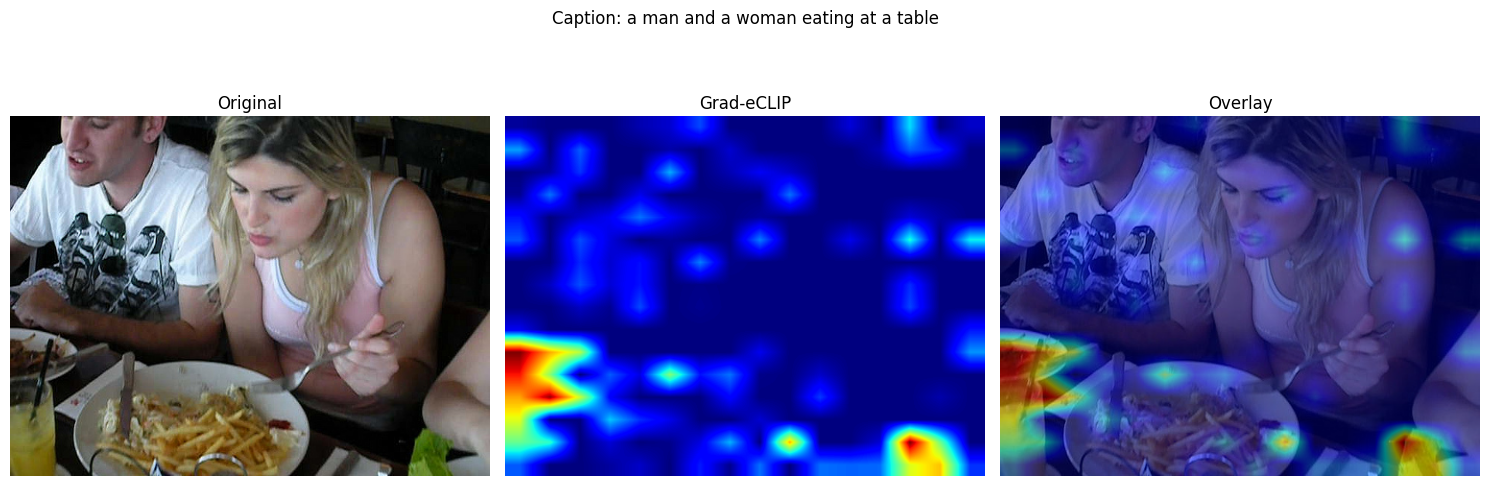

array([[[  0,   0,  76],
        [  0,   0,  76],
        [  0,   0,  76],
        ...,
        [ 22,  23, 112],
        [ 21,  22, 111],
        [ 21,  22, 111]],

       [[  0,   0,  76],
        [  0,   0,  76],
        [  0,   0,  76],
        ...,
        [ 22,  23, 112],
        [ 21,  22, 111],
        [ 21,  22, 111]],

       [[  0,   0,  76],
        [  0,   0,  76],
        [  0,   0,  76],
        ...,
        [ 22,  23, 112],
        [ 21,  22, 111],
        [ 21,  22, 111]],

       ...,

       [[ 35,  76, 134],
        [ 38,  79, 137],
        [ 42,  83, 141],
        ...,
        [ 60,  88, 193],
        [ 61,  89, 194],
        [ 61,  89, 194]],

       [[ 35,  75, 137],
        [ 37,  77, 139],
        [ 40,  81, 141],
        ...,
        [ 59,  87, 192],
        [ 60,  88, 193],
        [ 60,  88, 193]],

       [[ 35,  75, 138],
        [ 36,  76, 139],
        [ 39,  79, 141],
        ...,
        [ 59,  87, 192],
        [ 59,  87, 192],
        [ 60,  88, 193]]

In [28]:
index = np.random.randint(0, len(data))
# index = 5168
print(index)
image = data[index]['image']
attn_map, caption, raw_map = grad_eclip.generate_gradcam1(image)
print(f"Real Caption: {data[index]['caption_0']}")
print(f"Generated Caption: {caption}")
grad_eclip.visualize(image, attn_map, caption)

In [29]:
import os
os.makedirs("../data/heatmap/train", exist_ok=True)

In [36]:
for i in range(len(data)):
    image = data[i]['image']
    attn_map, _, _ = grad_eclip.generate_gradcam(image)
    file_name = f"../data/heatmap/train/{i}_hetmap.npy"
    np.save(file_name, attn_map)
    print(f"Index: {i}")

Index: 0
Index: 1
Index: 2
Index: 3
Index: 4
Index: 5
Index: 6
Index: 7
Index: 8
Index: 9
Index: 10
Index: 11
Index: 12
Index: 13
Index: 14
Index: 15
Index: 16
Index: 17
Index: 18
Index: 19
Index: 20
Index: 21
Index: 22
Index: 23
Index: 24
Index: 25
Index: 26
Index: 27
Index: 28
Index: 29
Index: 30
Index: 31
Index: 32
Index: 33
Index: 34
Index: 35
Index: 36
Index: 37
Index: 38
Index: 39
Index: 40
Index: 41
Index: 42
Index: 43
Index: 44
Index: 45
Index: 46
Index: 47
Index: 48
Index: 49
Index: 50
Index: 51
Index: 52
Index: 53
Index: 54
Index: 55
Index: 56
Index: 57
Index: 58
Index: 59
Index: 60
Index: 61
Index: 62
Index: 63
Index: 64
Index: 65
Index: 66
Index: 67
Index: 68
Index: 69
Index: 70
Index: 71
Index: 72
Index: 73
Index: 74
Index: 75
Index: 76
Index: 77
Index: 78
Index: 79
Index: 80
Index: 81
Index: 82
Index: 83
Index: 84
Index: 85
Index: 86
Index: 87
Index: 88
Index: 89
Index: 90
Index: 91
Index: 92
Index: 93
Index: 94
Index: 95
Index: 96
Index: 97
Index: 98
Index: 99
Index: 100

: 

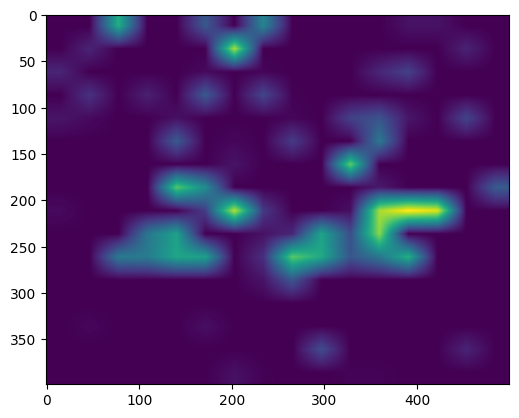

In [ ]:

# test = np.load("../data/heatmap/train/0_hetmap.npy")
# plt.imshow(test)